# Introduction

For this project I have chosen to build a political bias classifier that will work with natural language proecessing. Specifically this model will read article content and issue a binary classification of 0 (liberal bias) or 1 (conservative bias).  


#### Import Libraries

For this project I will be using tensorflow and keras for the modeling as well as numpy and pandas for the data manipulation.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam



#### Data Source 

The data source for this project is the All the News Dataset from kaggle.com (https://www.kaggle.com/snapcrack/all-the-news). This data includes articles from numerous different publications accross the political spectrum and includes roughly 150,000 total articles. This dataset will be the primary dataset used in training and evaluating my neural network. 

#### Importing Data

The data from kaggle is divided into three different csv files containing roughyl 50,000 articles each. Here I import all three files.

In [2]:
articles1_df = pd.read_csv('Data/articles1.csv')
articles2_df = pd.read_csv('Data/articles2.csv')
articles3_df = pd.read_csv('Data/articles3.csv')

## EDA

Before beginning preprocessing I would like to look at the data in detail to see which columns are available.

In [3]:
articles1_df.head(1)


,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...


All three csv files are stored in the same format. After taking a look at the columns available I can identify that there are three relevant columns that will be used in this analysis. These are publication, content

#### Evaluate Need for Data Cleaning

First I will check for duplicates and evaluate if they need to be removed. 

In [4]:
print(f' there are {articles1_df.duplicated().sum()} duplicates in articles1_df')
print(f' there are {articles2_df.duplicated().sum()} duplicates in articles2_df')
print(f' there are {articles3_df.duplicated().sum()} duplicates in articles3_df')

 there are 0 duplicates in articles1_df
 there are 0 duplicates in articles2_df
 there are 0 duplicates in articles3_df


There are no duplicates in any of the three dataframes so no actions are necessary here. 
##### Next I will check for na values and evaluate if any need to be removed.

In [5]:
print(articles1_df.isna().sum())
print('\n')
print(articles2_df.isna().sum())
print('\n')
print(articles3_df.isna().sum())

Unnamed: 0         0
id                 0
title              0
publication        0
author          6306
date               0
year               0
month              0
url            50000
content            0
dtype: int64


Unnamed: 0        0
id                0
title             1
publication       0
author         8598
date           2626
year           2626
month          2626
url            7011
content           0
dtype: int64


Unnamed: 0       0
id               0
title            1
publication      0
author         972
date            15
year            15
month           15
url              0
content          0
dtype: int64


There are a number of null values in the author, data, year, month, and url columns present in all three dataframes. Luckily, none of these columns will be used in the modeling process so I can safely ignore these values and continue with the EDA process. Additionally, I do not need to evaluate numeric data for inf or 0 values as the data that is relevant to the analysis is exclusively text data from the title and content columns.

#### Look into df contents

Here I need to obtain the list of publishers that are present in the data in order to decide which publishers are to be assigned bias labels and used in training the model.

In [6]:
pd.unique(articles1_df['publication'])

array(['New York Times', 'Breitbart', 'CNN', 'Business Insider',
       'Atlantic'], dtype=object)

In [7]:
pd.unique(articles2_df['publication'])

array(['Atlantic', 'Fox News', 'Talking Points Memo', 'Buzzfeed News',
       'National Review', 'New York Post', 'Guardian'], dtype=object)

In [8]:
pd.unique(articles3_df['publication'])

array(['Guardian', 'NPR', 'Reuters', 'Vox', 'Washington Post'],
      dtype=object)

### Preprocessing

#### Assign Bias Labels

In order to assign bias labels I have used the allsides.com bias ratings (https://www.allsides.com/media-bias/media-bias-ratings) and the adfontesmedia.com bias ratings (https://www.adfontesmedia.com/interactive-media-bias-chart/) to make these determinations. Liberal publishers are assignd a bias label of 0 where conservative publishers are assigned a bias label of 1. 

There are many publishers in this dataset that are rated to be neural in their political bias such as business insider, reuters and several others. These neutral publishers will not be used in the training of the model however I have assigned them a 0 bias (liberal) simply because it was easier to execute using the np.where command. Please not that many of the publishers assigned a 0 in the next step are not relevant to the analysis. 

In [9]:
articles1_df['Bias'] = np.where((articles1_df['publication'] == 'Breitbart'), 1, 0)

articles2_df['Bias'] = np.where((articles2_df['publication'] == 'Fox News') | 
                                (articles2_df['publication'] == 'New York Post'), 1, 0)
articles3_df['Bias'] = 0 

#### Identify relevant Publishers

In this step I have isolated rows associated with publishers with at least a moderate conservative or liberal bias. This step is done to make concatenation into a single dataframe easier later on. 

In [10]:
Breit = articles1_df[articles1_df['publication'] == 'Breitbart']
Atlantic = articles2_df[articles2_df['publication'] == 'Atlantic']
Foxnews = articles1_df[articles1_df['publication'] == 'Fox News']
NYT = articles1_df[articles1_df['publication'] == 'New York Times']
NYP = articles2_df[articles2_df['publication'] == 'New York Post']
Wash = articles3_df[articles3_df['publication'] == 'Washington Post']
Guardian = articles3_df[articles3_df['publication'] == 'Guardian']
Vox = articles3_df[articles3_df['publication'] == 'Vox']

In [11]:
NYT.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,Bias
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,0
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",0
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",0
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...",0
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",0


#### See Row Counts for Each Publisher

In [12]:
print(f'Breitbart {Breit.shape}')
print(f'Atlantic {Atlantic.shape}')
print(f'Fox news {Foxnews.shape}')
print(f'New York Times {NYT.shape}')
print(f'New York Post {NYP.shape}')
print(f'Washington Post {Wash.shape}')
print(f'Guardian {Guardian.shape}')
print(f'Vox {Vox.shape}')

Breitbart (23781, 11)
Atlantic (7008, 11)
Fox news (0, 11)
New York Times (7803, 11)
New York Post (17493, 11)
Washington Post (11114, 11)
Guardian (3808, 11)
Vox (4947, 11)


#### Select most Biased Publishers for Model Training.

As I am trying to train a model for binary classification, I have tried to select the most biased publishers in my dataset for training the model. Towards this end I have selected Breitbart, The New York Times, the New York Post, and the Atlantic for use in training the model. 

Disclaimer: The bias ratings from allsides.com and adfontes media indicate that the liberal sources of the Atlantic and The New York Times are of a moderate liberal bias score where the conservative sources of Breitbart and the New York Post were given a conservative and moderate conservative bias score respectively. This means that the conservative articles on average are more conservative than the liberal articles are liberal. Given the lack of far left publishers in my dataset this is unavoidable however when interpreting the results of the model it must be taken into account. 

In [13]:
Publishers = [Breit,NYT,NYP,Atlantic] # Assign Publishers 
articles = pd.concat(Publishers) # Concatenate publisher DataFrames into a single articles DataFrame

#### Evaluate Class Distribution



In [14]:
print(articles.shape)
articles['Bias'].sum()

(56085, 11)


41274

With 41274 out of 56085 articles having a conservative bias there is a definite class imbalance in the target field. I will keep an eye on the results to evaluate if this needs to be corrected. For now I will leave it as is. 

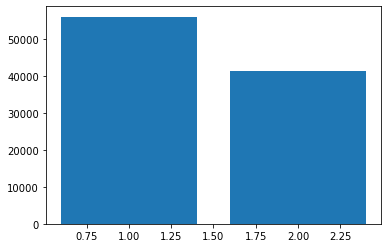

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar((1,2),(56085, 41274))
plt.show()

#### Review final DataFrame

In this section I have extracted the fields that I will be using in the analysis. All fields are showing up as expected and there do not appear to be any issues. There are 56,085 rows in the dataset that will be used for training and testing. 

In [16]:
articles[['title','content','Bias']].head(5)

,title,content,Bias
7803,CNN’s Zeleny: ’Hard to Imagine’ Obama Would Ha...,On Tuesday’s broadcast of CNN’s “Situation Roo...,1
7804,American Students on Spring Break Chant ’Build...,A group of American spring break revelers repo...,1
7805,Surge in ’Honour Crimes’ and Forced Marriages ...,“honour crimes” have risen by 40 per cent in...,1
7806,MILO Announces New Media Venture - Breitbart,Former Breitbart Senior Editor MILO has announ...,1
7807,Jared Kushner at Center of Media Spotlight on ...,The focus of the continuous media reports of a...,1


In [17]:
articles.shape

(56085, 11)

#### Extract Features and Combine

In this section features and targets will be extracted. As you can see there is a single relevant feature columm in the content column. The target column will be the Bias label that was created earlier in the workbook.

In [18]:
X = articles['content']
y = articles['Bias']

#### Remove possibly problematic works from the data.

In this section I will remove possibly problematic works from the feature data. These words include the names of publishers. I have also removed a few locations from the data such as New York and Washington as these are disproportionately used by certain publishers. 


In [19]:
X = [word.replace('Breitbart','') for word in X]
X = [word.replace('CNN','') for word in X]
X = [word.replace('Atlantic','') for word in X]
X = [word.replace('New York Times','') for word in X]
X = [word.replace('New York','') for word in X]
X = [word.replace('Washington','') for word in X]
X = [word.replace('London','') for word in X]

#### Test Train Split

Now that most of the data processing is done it is time to do the test train split. I have chosen to stratify the split to ensure that the classes are equally represented. I have also chosen a test size of 10% in order to maximize the amount of data available for training. There will still be 5

In [20]:
from sklearn.model_selection import train_test_split

# split train and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

#### Import Google Universal Sentence Encoder

The universal sentence encoder is a tool that was built by google with the intention to be used for natural language processing tasks. The encoder takes an english string input that can be of word, sentence, paragraph or even article length and converts the data into a 512 value fixed dimensional embedding representation of the string. This document explains in more detail how the embedder works (https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46808.pdf) 

The embedding weights have been pre-trained so all that is needed is to import the embedder and to embed all of the relevant article content. These steps are performed in the cells directly below.

In [21]:
# Tensorflow hub is needed to use the encoder
import tensorflow_hub as hub

# Import the encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


#### Embed X Train

In [22]:
# Import Time function to track how long the embedding takes.
import time

# Create new list which new embedded values will be appended to. 
new_X_train = []

# Loop through all rows in the X_train set and embed each value.
start_time = time.time()
for row in range(len(X_train)):
    new_X_train.append(embed([X_train[row]]))
    
print("--- %s seconds ---" % (time.time() - start_time))




--- 180.1952419281006 seconds ---


#### Embedd X Test

The same steps are performed to embed the test set. 

In [23]:
new_X_test = []

start_time = time.time()
for row in range(len(X_test)):
    new_X_test.append(embed([X_test[row]]))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 20.063282012939453 seconds ---


#### Stack embedded values

Here I use the np.stack function to stack all of the embedded arrays into a single array. This step is necessary for a neural network to reach the input. 

Additionally, in this step I also convert the y_train and y_test sets into numpy arrays as this format is necessary for a neural network to use them.

In [31]:
# Stack X values
X_train2 = np.stack(new_X_train[0:len(X_train)], axis=0)
X_test2 = np.stack(new_X_test[0:len(X_train)], axis=0)

# Stack y values
y_train2 = np.array(y_train[0:len(y_train)])
y_test2 = np.array(y_test)

In [32]:
# Reshape to remove extraneous column
X_train2 = X_train2.reshape(50476,512)
X_test2 = X_test2.reshape(5609,512)

### Build Neural Network

The neural network structure that I have chosen features an input layer of 512 neurons corresponding with the 512 numeric features produced by the google universal sentence encoder. The next layer is a hidden layer with 40 neurons, this number was arrived at by trial and error. I tried various different structures of layers and neurons and found that this number produced the best results of the iterations that I attempted. 

In general this model had a significant tendency to overfit so having more than one hidden layer was simply not necessary in order to generate good accuracy. Additionally, a dropout layer is included here as well as a lower than standard learning rate (.005) to reduce the overfitting tendency.

This is a binary classification problem so I made the determination that the sigmoid output function with a binary crossentropy loss function is most applicable. I went with the Adam optimizer as this seemed to perform well relavtive to the other optimizers that I used. 

In [40]:
# Build the model
model = tf.keras.Sequential()

# Define Layers
model.add(Dense(40, input_dim =512, activation='relu')),
model.add(Dropout(0.4)),
model.add(Dense(1, activation='sigmoid'))

#Define Optimizer
opt = keras.optimizers.Adam(learning_rate=0.0005)

#Compile Model
model.compile(loss=tf.keras.losses.binary_crossentropy,optimizer=opt,  metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 40)                20520     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 41        
Total params: 20,561
Trainable params: 20,561
Non-trainable params: 0
_________________________________________________________________


#### Train Neural Network

In [41]:
history = model.fit(X_train2, y_train2 , epochs=50, validation_data=(X_test2, y_test2), shuffle=True)

Epoch 1/50
1578/1578 [==============================] - 1s 755us/step - loss: 0.3902 - accuracy: 0.8299 - val_loss: 0.3053 - val_accuracy: 0.8748
Epoch 2/50
1578/1578 [==============================] - 1s 725us/step - loss: 0.2992 - accuracy: 0.8750 - val_loss: 0.2837 - val_accuracy: 0.8809
Epoch 3/50
1578/1578 [==============================] - 1s 713us/step - loss: 0.2829 - accuracy: 0.8834 - val_loss: 0.2725 - val_accuracy: 0.8859
Epoch 4/50
1578/1578 [==============================] - 1s 711us/step - loss: 0.2736 - accuracy: 0.8880 - val_loss: 0.2658 - val_accuracy: 0.8884
Epoch 5/50
1578/1578 [==============================] - 1s 732us/step - loss: 0.2653 - accuracy: 0.8915 - val_loss: 0.2603 - val_accuracy: 0.8912
Epoch 6/50
1578/1578 [==============================] - 1s 712us/step - loss: 0.2598 - accuracy: 0.8937 - val_loss: 0.2550 - val_accuracy: 0.8953
Epoch 7/50
1578/1578 [==============================] - 1s 714us/step - loss: 0.2544 - accuracy: 0.8967 - val_loss: 0.2494 -

#### Evaluate Results

In order to evaluate the results I have plotted the training and testing accuracies using matplotlib. The Accuracies that I was able to achieving using this model seemed to max out at around 93%. 

I believe that this is an acceptable accuracy given the strategy that I have employed. Is it likely that some of the misclassified articles were actually classified correctly but were incorrectly labeled as conservative or liberal. It is also possible that there are some articles in the dataset that are largely unbiased but were labeled as liberal or conservative, in these instances the accuracy of the classification should in theory be close to 50%. 

In [42]:
model.evaluate(X_test2, y_test2)

176/176 [==============================] - 0s 627us/step - loss: 0.2070 - accuracy: 0.9224


[0.2070254683494568, 0.922446072101593]

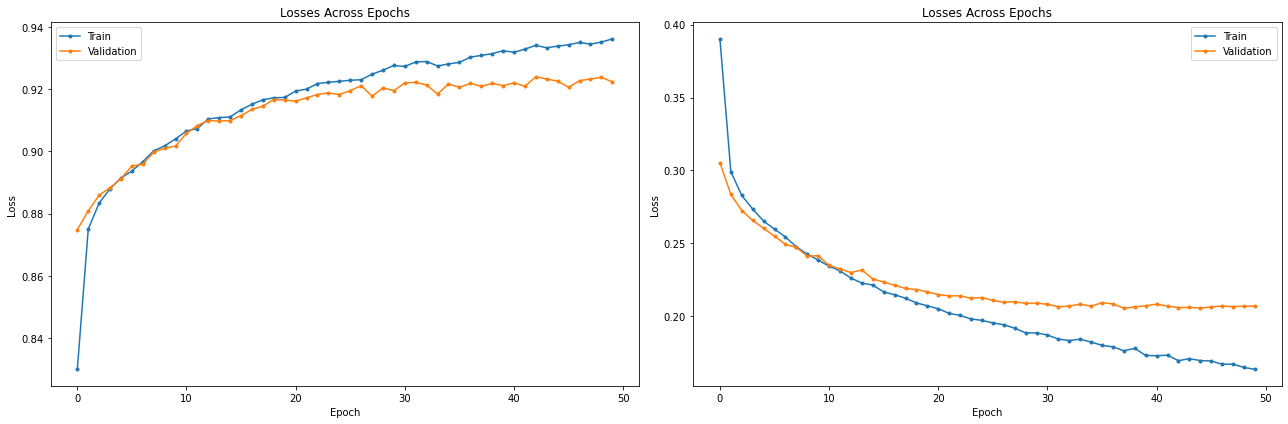

In [43]:
import matplotlib.pyplot as plt

# Set up two subplots
plt.subplots(1, 2, figsize=(18, 6))

# Plot accuracies
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', marker='.')
plt.plot(history.history['val_accuracy'], label='Validation', marker='.')
plt.title('Losses Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


# Plot losses
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', marker='.')
plt.plot(history.history['val_loss'], label='Validation', marker='.')
plt.title('Losses Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# This ensures the subplots do not overlap
plt.tight_layout()

# Show the subplots
plt.show()

The model did not require many epochs to reach its maximum accuracy score even with the measures implemented to reduce overfitting. You can see from the charts above that the model begins to overfit after roughly 20 epochs and the validation accuracy reaches its maximum around 35 epochs.

Despite the overfitting the validation accuracy does not significanly drop immediatly as the model overfits. For that reason I have chosen to leave the model fitted on 50 epochs. 



## Conclusion

I have successfully developed a neural network that can predict political bias (as I have defined it) in biased news articles. I believe that the level of accuracy of the model is sufficient for application in the next stage of the project which is a google chrome extension that will make use of the fitted model alongside a real time web scraper to make political bias determinations on news webpages.